## Trade call Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
stock_df = pd.read_csv("ITC.csv")
stock_df.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,ITC,EQ,15-May-2017,274.95,275.9,278.9,275.50,278.5,277.95,277.78,5462855,1.517477e+09,52501,4128324,75.57
1,ITC,EQ,16-May-2017,277.95,278.5,284.3,278.00,283.0,283.45,280.93,11204308,3.147583e+09,98347,8307567,74.15
2,ITC,EQ,17-May-2017,283.45,284.1,284.4,279.25,281.5,281.65,281.56,8297700,2.336261e+09,99107,5924804,71.40


In [32]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df["botlinger_avg"] = stock_df["Close Price"].rolling(window=14).mean()
stock_df["botlinger_upper"] = stock_df["Close Price"].rolling(window=14).mean() + 2*stock_df["Close Price"].rolling(window=14).std()
stock_df["botlinger_lower"] = stock_df["Close Price"].rolling(window=14).mean() - 2*stock_df["Close Price"].rolling(window=14).std()

stock_df.tail(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,botlinger_avg,botlinger_upper,botlinger_lower
493,ITC,EQ,2019-05-09,300.65,299.4,301.30,296.35,299.85,299.85,299.17,10223616,3.058551e+09,129794,5965688,58.35,303.710714,308.374681,299.046748
494,ITC,EQ,2019-05-10,299.85,300.0,300.45,296.90,297.15,297.75,298.68,6904657,2.062297e+09,132469,4024203,58.28,303.035714,308.229561,297.841868
495,ITC,EQ,2019-05-13,297.75,295.1,303.50,287.70,288.80,289.30,296.21,35880558,1.062813e+10,226154,14476904,40.35,301.957143,310.870301,293.043984


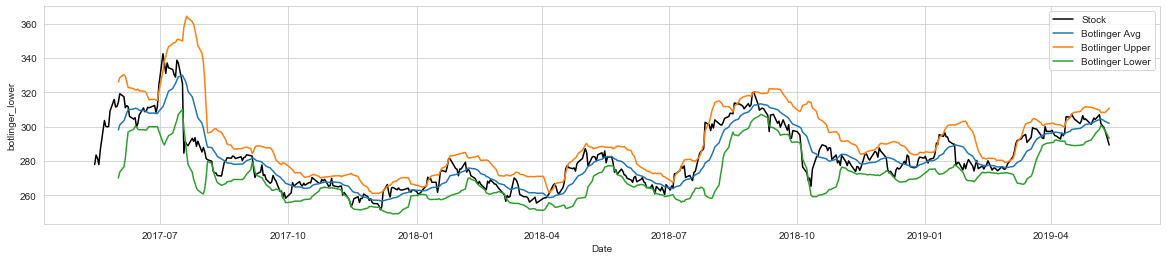

In [36]:
plt.figure(figsize=(20,4))
sns.set_style("whitegrid")
sns.lineplot(x="Date", y="Close Price", data=stock_df,color="black")
sns.lineplot(x="Date", y="botlinger_avg", data=stock_df)
sns.lineplot(x="Date", y="botlinger_upper", data=stock_df)
sns.lineplot(x="Date", y="botlinger_lower", data=stock_df)
plt.legend(labels=["Stock","Botlinger Avg","Botlinger Upper","Botlinger Lower"])
plt.show()

In [65]:
mask = stock_df["Close Price"]<stock_df["botlinger_lower"]
stock_df.loc[mask,"call"] = "Buy"

mask = (stock_df["Close Price"]>=stock_df["botlinger_lower"]) & (stock_df["Close Price"]<stock_df["botlinger_avg"])
stock_df.loc[mask,"call"] = "Hold Buy/Liqiudate Short"

mask = (stock_df["Close Price"]>=stock_df["botlinger_avg"]) & (stock_df["Close Price"]<=stock_df["botlinger_upper"])
stock_df.loc[mask,"call"] = "Hold Short/Liqiudate Buy"

mask = (stock_df["Close Price"]>stock_df["botlinger_upper"])
stock_df.loc[mask,"call"] = "Short"

In [82]:
stock_df = stock_df[stock_df["call"].isnull()==False]
stock_df.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,botlinger_avg,botlinger_upper,botlinger_lower,call
13,ITC,EQ,2017-06-01,311.8,312.0,316.75,310.8,315.0,314.20,315.10,8253042,2.600519e+09,91321,4704937,57.01,298.089286,326.064967,270.113605,Hold Short/Liqiudate Buy
14,ITC,EQ,2017-06-02,314.2,316.1,319.90,315.2,319.3,319.20,317.86,11073749,3.519852e+09,65848,7008906,63.29,301.035714,328.559730,273.511699,Hold Short/Liqiudate Buy
15,ITC,EQ,2017-06-05,319.2,315.0,318.25,313.3,317.5,317.45,316.83,9482413,3.004339e+09,69774,6130621,64.65,303.464286,330.295422,276.633149,Hold Short/Liqiudate Buy


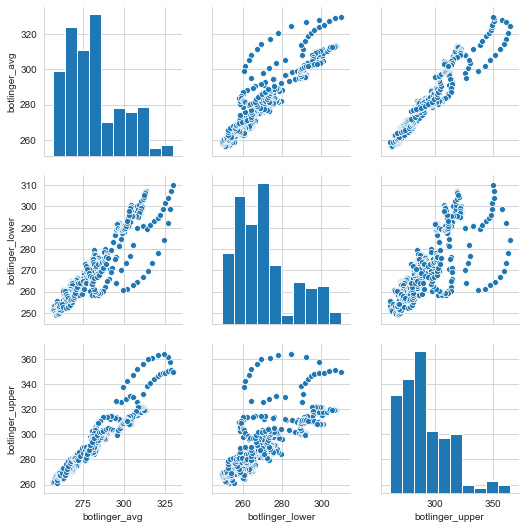

In [85]:
sns.pairplot(stock_df[["botlinger_avg","botlinger_lower","botlinger_upper","call"]])

## Trade call Prediction

In [111]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = stock_df[["botlinger_avg","botlinger_lower","botlinger_upper"]]
Y = stock_df.call.astype('category')

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42 )

In [129]:
# Logistics regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='auto', solver="lbfgs")
log_reg.fit(X_train, y_train)

print("Training Acc:",log_reg.score(X_train, y_train)*100,"%")
print("Test Acc:",log_reg.score(X_test, y_test)*100,"%")

Training Acc: 49.112426035502956 %
Test Acc: 42.758620689655174 %


In [130]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("Training Acc:",clf.score(X_train, y_train)*100,"%")
print("Test Acc:",clf.score(X_test, y_test)*100,"%")

Training Acc: 100.0 %
Test Acc: 55.172413793103445 %


In [131]:
# K - Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Training Acc:", knn.score(X_train, y_train)*100,"%")
print("Test Acc:", knn.score(X_test, y_test)*100,"%")

Training Acc: 66.5680473372781 %
Test Acc: 57.24137931034483 %


In [132]:
# Support-Vector Machines
from sklearn.svm import SVC

svm = SVC(gamma="auto")
svm.fit(X_train, y_train)

print("Training Acc:", svm.score(X_train, y_train)*100,"%")
print("Test Acc:", svm.score(X_test, y_test)*100,"%")

Training Acc: 78.10650887573965 %
Test Acc: 56.55172413793104 %


### Prediction for stock2 using Model

In [145]:
stock2_df = pd.read_csv("RELIANCE.csv")

stock2_df['Date'] = pd.to_datetime(stock2_df['Date'])
stock2_df["botlinger_avg"] = stock2_df["Close Price"].rolling(window=14).mean()
stock2_df["botlinger_upper"] = stock2_df["Close Price"].rolling(window=14).mean() + 2*stock2_df["Close Price"].rolling(window=14).std()
stock2_df["botlinger_lower"] = stock2_df["Close Price"].rolling(window=14).mean() - 2*stock2_df["Close Price"].rolling(window=14).std()

stock2_df = stock2_df[stock2_df["botlinger_avg"].isnull()==False]

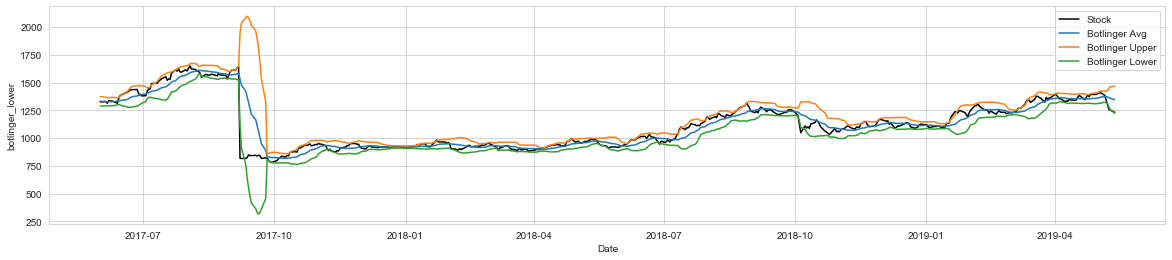

In [146]:
plt.figure(figsize=(20,4))
sns.set_style("whitegrid")
sns.lineplot(x="Date", y="Close Price", data=stock2_df,color="black")
sns.lineplot(x="Date", y="botlinger_avg", data=stock2_df)
sns.lineplot(x="Date", y="botlinger_upper", data=stock2_df)
sns.lineplot(x="Date", y="botlinger_lower", data=stock2_df)
plt.legend(labels=["Stock","Botlinger Avg","Botlinger Upper","Botlinger Lower"])
plt.show()

In [151]:
# Using the same KNN Model

stock2_df["call"] = knn.predict(stock2_df[["botlinger_avg","botlinger_lower","botlinger_upper"]])
stock2_df.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,botlinger_avg,botlinger_upper,botlinger_lower,call
13,RELIANCE,EQ,2017-06-01,1340.70,1332.70,1340.0,1323.00,1329.85,1328.25,1329.31,2179328,2.896998e+09,79314,1229535,56.42,1332.289286,1374.066261,1290.512310,Hold Short/Liqiudate Buy
14,RELIANCE,EQ,2017-06-02,1328.25,1335.00,1338.7,1317.00,1322.90,1324.75,1326.29,2627565,3.484909e+09,92530,1625375,61.86,1330.907143,1372.279297,1289.534988,Hold Short/Liqiudate Buy
15,RELIANCE,EQ,2017-06-05,1324.75,1326.25,1341.0,1315.85,1330.00,1329.35,1328.64,2476706,3.290663e+09,77234,1452622,58.65,1328.982143,1367.686657,1290.277629,Hold Short/Liqiudate Buy


## Trade call prediction using RandomForest

In [361]:
stock_data = pd.read_csv("RELIANCE.csv")
stock_data.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,RELIANCE,EQ,15-May-2017,1350.45,1356.40,1356.40,1333.50,1343.6,1344.1,1344.22,1540213,2.070379e+09,75812,802733,52.12
1,RELIANCE,EQ,16-May-2017,1344.10,1346.05,1376.90,1341.00,1356.2,1356.3,1360.59,2892947,3.936121e+09,79767,1238129,42.80
2,RELIANCE,EQ,17-May-2017,1356.30,1353.00,1365.95,1347.75,1350.0,1353.1,1354.16,2250304,3.047263e+09,56277,1225837,54.47


In [362]:
stock_data["Per_chg_oc"] =  ((stock_data["Close Price"]-stock_data["Open Price"])/stock_data["Open Price"])*100
stock_data["Per_chg_lh"] =  ((stock_data["High Price"]-stock_data["Low Price"])/stock_data["Low Price"])*100

stock_data["Per_chg_day"] = stock_data["Close Price"].pct_change()*100
stock_data.drop(stock_data.index[0],inplace=True)

stock_data["roll_avg"] = stock_data["Close Price"].rolling(window=5).mean()
stock_data["roll_std"] = stock_data["Close Price"].rolling(window=5).std()
stock_data = stock_data[stock_data["roll_avg"].isnull()==False]

stock_data.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,Per_chg_oc,Per_chg_lh,Per_chg_day,roll_avg,roll_std
5,RELIANCE,EQ,22-May-2017,1318.85,1326.5,1333.60,1315.2,1326.00,1324.15,1322.82,2011859,2.661318e+09,89828,1123947,55.87,-0.177158,1.399027,0.401865,1335.95,17.420211
6,RELIANCE,EQ,23-May-2017,1324.15,1325.7,1329.85,1302.0,1304.55,1305.55,1313.55,2108223,2.769247e+09,81667,1172410,55.61,-1.519952,2.139017,-1.404675,1325.80,17.383757
7,RELIANCE,EQ,24-May-2017,1305.55,1307.5,1313.70,1295.1,1299.00,1297.70,1302.71,3274804,4.266122e+09,78535,1782580,54.43,-0.749522,1.436183,-0.601279,1314.72,12.641875


In [363]:
stock_df = stock_data.copy()
stock_df["Action"]=1

for i in range(489):
    if stock_df["Close Price"].iloc[i+1]>stock_df["Close Price"].iloc[i]:
        stock_df.iloc[i,20]=1
    elif stock_df["Close Price"].iloc[i+1]<stock_df["Close Price"].iloc[i]:
        stock_df.iloc[i,20]=-1

stock_df.head(3)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,...,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,Per_chg_oc,Per_chg_lh,Per_chg_day,roll_avg,roll_std,Action
5,RELIANCE,EQ,22-May-2017,1318.85,1326.5,1333.60,1315.2,1326.00,1324.15,1322.82,...,2.661318e+09,89828,1123947,55.87,-0.177158,1.399027,0.401865,1335.95,17.420211,-1
6,RELIANCE,EQ,23-May-2017,1324.15,1325.7,1329.85,1302.0,1304.55,1305.55,1313.55,...,2.769247e+09,81667,1172410,55.61,-1.519952,2.139017,-1.404675,1325.80,17.383757,-1
7,RELIANCE,EQ,24-May-2017,1305.55,1307.5,1313.70,1295.1,1299.00,1297.70,1302.71,...,4.266122e+09,78535,1782580,54.43,-0.749522,1.436183,-0.601279,1314.72,12.641875,1


In [368]:
# RandomForest Classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = stock_df[["Per_chg_oc","Per_chg_lh","roll_avg","roll_std"]]
Y = stock_df.Action.astype('category')

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42 )

In [374]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train,y_train)

print("Training Acc:", clf.score(X_train, y_train)*100,"%")
print("Test Acc:", clf.score(X_test, y_test)*100,"%")

Training Acc: 100.0 %
Test Acc: 54.421768707483 %
